# [Q1] Hashing
-----

### Libraries

In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics
import scipy.integrate as integrate
import math
from tqdm import tqdm

## Hash function
As a hash function we decide to use the following hash funcion<. <br>
 <center>$h(x_1,...,x_n) = \sum_{i=1}^m \alpha_i x_i$ mod  n  </center>
 where :
- $\alpha_i$ are chosen at random in the range $(0,n-1)$
- $x_i$ are the conversion in digit of the character of the string
- n is a prime number higher than 1000
To decrease the number of collisions we fix n equals to $2^{31}-n$ and we decide to convert the letters of the string in numerical value.

In [2]:
def hash_func(s,n,A):
    out = 0
    for i in range(len(s)):
        if s[i].isdigit(): 
            out += A[i]*int(s[i])
        else:
            out += A[i]*(ord(s[i])-87) #if the value of the string is a letter we consider the numerical position of it in the alphabet
    
    out = out%n #mod n 
    out = '{0:031b}'.format(out)
    out = out[-31:]
    return out

First of all we check if the hashing function maps elements to binary numbers in uniformly distributed

In [14]:
file = open("hash.txt", "r")

In [15]:
n = (2**31)-1
len_string = 33
A = random.sample(range(0, n-1), len_string + 1)

y = []
for line in file:
    val = hash_func(line, n, A)
    y.append(int(val, 2))

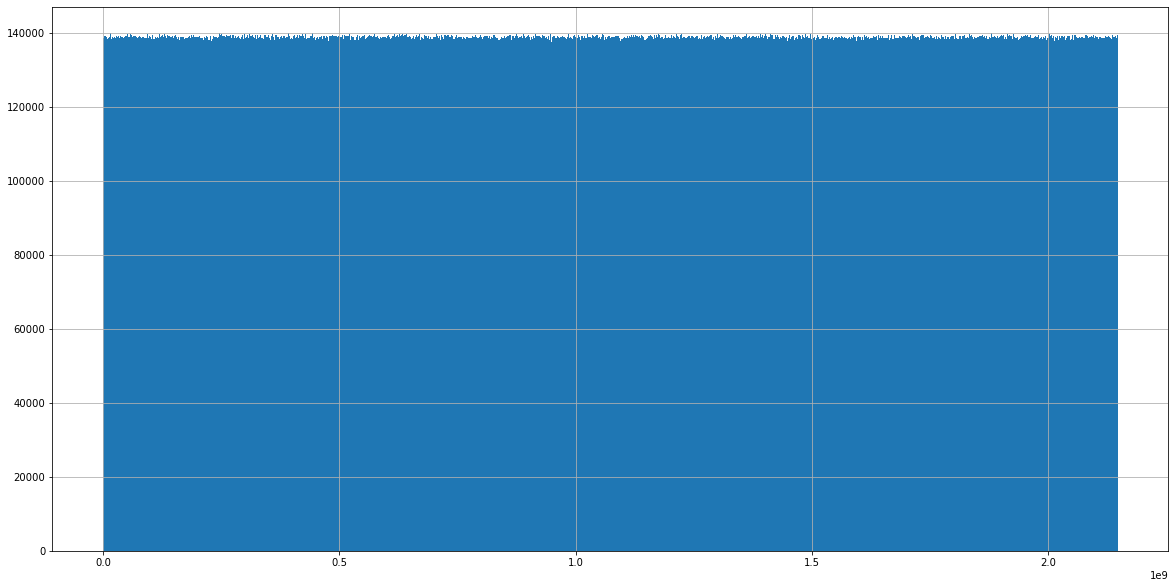

In [18]:
plt.figure(figsize=(20, 10))
plt.hist(y, bins = 1000)
plt.grid()
plt.show()

### The Flajolet–Martin algorithm

We have a multiset of elements and we wanted to compute the cardinality of the multiset.
Assume our multiset as $S$, with elements $e_1, e_2, ...,  e_n$. 

Lets say we are given a function $hash\_func(e_j)$ which maps elements to binary numbers in uniformly distributed over range $0$ to $2^L-1$.

We also hold a hash called *BITMAP* of size $L$ and initiate all the values to $0$. Now we loop through all the hashed values and we find the least significant $1$-bit as $x$, then we mark that *BITMAP*$[x]$ as $1$.

If we find the smallest index $i$ in *BITMAP* such that *BITMAP*$[i] = 0$ , then , we can estimate that cardinality of the multiset as $2^i$ .

In [3]:
file = open("hash.txt", "r")

In [4]:
len_strings = 33
n = (2**31)-1
A = random.sample(range(0, n-1), len_strings + 1)

In [5]:
def f_p(y): #returns the least significant 1-bit of y
    if int(y, 2) == 0:
        return 26
    
    k = int(len(y)-1)
    while 1:
        if int(y[k]) != 0:
            return int(len(y)-1) - k
        k -= 1   #the min k such that bit(y,k) ≠ 0

In [9]:
bitmax = np.zeros(32)

for line in file:
    el = hash_func(line, n, A)
    x = f_p(el)
    bitmax[x] = 1
    
print("BITMAP : " + str(bitmax))

idx = 0
while bitmax[idx]!=0:
    idx+=1

print("Index : " + str(idx))

#estimated cardinality
est_card = pow(2,idx)

print("Estimated cardinality : " + str(est_card))


BITMAP : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0.]
Index : 27
Estimated cardinality : 134217728


In [10]:
err = ((est_card/125000000)-1)*100
print(str(round(err, 3))+"%")

7.374%


### HyperLogLog Algorithm

The input is a set of data items $S$, that is, a stream whose elements are read
sequentially. The output is an estimate of the cardinality, defined as the number of distinct elements
in $S$. 

Given a binary string $s \in S$, let $\rho(s)$ represent the position of the leftmost $1$ (equivalently one plus the length of the initial run of $0$’s). 

Each element of $S$ is split into subsets $S_1, S_2, ... , S_m$ based on the first $M$ bits of hashed values, where $m = 2^M$. For each subset $S_j$ we define:

$S^{(j)} = Max(S_j):=\max\limits_{x \in S_j}\rho (x)$

The estimated cardinality is:

$E:=\alpha_{m}m^{2}Z$

Where:

* $\alpha_m := \bigg(m{\displaystyle\int}_{0}^{\infty}\bigg( log_2\big( {{2+u}\over{1+u}} \big) \bigg)^{m}du\bigg)^{-1}$

* $m = 2^M$

* $Z = \bigg( \displaystyle\sum\limits_{j=1}^{m}2^{-S^{(j)}} \bigg)^{-1}$

In [3]:
# Given a binary number as a string it counts the number of zeros before the first 1
def countZeros(num):
    count = 0
    for bit in num:
        count+=1
        if int(bit) != 0:
            return count
    return len(num)

In [4]:
# This is the function that needs to be integrated to calculate alpha_m
def func(u, m):
    return (math.log2((2+u)/(1+u)))**m

In [5]:
def alpha_m(m):
    
    integral = integrate.quad(func, 0, np.infty, args = (m))[0]
    
    return (integral*m)**(-1)

In [6]:
def getBuckets(M, buckets, value, n, A):
    
    binary_num = hash_func(value, n, A)

    m = 2**M
    
    num_zeros = countZeros(binary_num[M:])
    if buckets[int(binary_num[:M], 2)] < num_zeros:
        buckets[int(binary_num[:M], 2)] = num_zeros
    
    return buckets

In [7]:
def hyperLogLog(buckets, M):
    
    m = 2**M
    Z = 0
    for bucket in buckets:
        Z += 2**(-bucket)
    Z = Z**(-1)

    card = (m**2)*Z*alpha_m(m)
    
    return card

In [37]:
file = open("hash.txt", "r")

In [38]:
len_strings = 33
n = (2**31)-1 #primary number
A = random.sample(range(0, n-1), len_strings + 1)

In [10]:
M = 13
buckets = np.zeros(2**M)

for line in file:
    buckets = getBuckets(M, buckets, line, n, A)

print("Buckets : " + str(buckets))

Buckets : [17. 13. 15. ... 16. 14. 18.]


In [33]:
HLL = hyperLogLog(buckets, M)
print("Estimated cardinality : " + str(HLL))

Estimated cardinality : 125960784.13902305


In [34]:
err = ((HLL/125000000)-1)*100
print("error : " + str(round(err, 3))+"%")

error : 0.769%


For $m$ buckets, the avarage error is $\displaystyle{1.3}\over{\sqrt{m}}$

In [29]:
m = 2**M
err2 = (1.3/(m**(1/2)))*100
print("avarage error : "+str(round(err2, 3)) + "%")

avarage error : 1.436%


After others tests of the HyperLogLog on the same set, we got the following results:

* Estimated cardinality : $127147271.53884749$

* error : $1.718\%$

* Estimated cardinality : $123188423.96773018$

* error : $1.449\%$

If we average the errors, as we can see, the final result is closer to $1.436\%$:

${{1.718\% + 0.769\% + 1.449\%} \over {3}} = 1.312\%$

# [Q2] Clustering
-----

### Libraries

In [1]:
# Generic imports
import pandas as pd
from collections import defaultdict
from collections import Counter
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats

# Text mining
import nltk
from nltk.corpus import stopwords
import string
import re
from nltk.stem import PorterStemmer
from ast import literal_eval
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud

## Cleaning the Data

In [68]:
dataset = pd.read_csv('/content/drive/MyDrive/ADM-HW4/Reviews.csv')
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
dataset.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

We can see that there are null values only in the columns `ProfileName` and `Summary`. In the next cell er are going to fill only the summary column with empty string because for our purposes we don't need the profile name that will be dropped.

In [ ]:
dataset['Summary'].fillna('', inplace=True)

In order to have a better understading of the type of product we group the column summary and text together.

In [ ]:
dataset['Text'] = dataset['Summary'] + ' ' + dataset['Text'] 

We drop the columns that we don't need to use for this homework.

In [69]:
dataset.drop(['ProfileName','HelpfulnessNumerator',
              'HelpfulnessDenominator','Time','Summary'],axis=1, inplace=True)
dataset.head()

,Id,ProductId,UserId,Score,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


Our task is to cluster the product so we apply a groupby on `ProductId`.

In [70]:
df = dataset.groupby('ProductId')['Text'].apply(lambda x: ' '.join(x)).reset_index()
df.head()

,ProductId,Text
0,0006641040,"These days, when a person says, ""chicken soup""..."
1,141278509X,This product by Archer Farms is the best drink...
2,2734888454,My dogs loves this chicken but its a product f...
3,2841233731,This book is easy to read and the ingredients ...
4,7310172001,This product is a very health snack for your p...


In [ ]:
df.shape

(74258, 2)

# Text Mining
We want to cluster the products using the reviews that we can find in the column `Text` of our dataset. In order to do this we need to represent the reviews as TF-IDF score used in the previous homework.

In the list of stop words we insert words that don't add information about the product they are refering to.

In [59]:
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union({'br','product','http','lot','time','item','everith','someone','thing','bit','anyth','thank', 'time', 'way', 'thing', 'stuff', 'really', 'taste','flavor','brand','review','packag','someth','one','day','great','groceri','store','year','tast','order','peopl','problem','ingredi'})
ps = PorterStemmer()

In [ ]:
def clean_text(text):
    words = word_tokenize(text)    #tokenizing the text
    tagged = nltk.pos_tag(words)   #tag help us to understand what kind of word is 
    good_words = ""                # list of cleaned words
    for word,tag in tagged:
        if tag == 'NN' or tag == 'NNS' or tag =='NNPS' or tag == 'NNP': #filter on the words
            if word.lower() not in stop_words and word.isalpha() and word.lower() not in string.punctuation:
                good_words += ps.stem(word).lower() + " "
    return good_words.strip()

In [ ]:
# Cleaning the column 'Text_Words'
df['Text_Words'] = df.Text.apply(lambda x: clean_text(x))
df.head()

,ProductId,Text,Text_Words
0,0006641040,Read it once. Read it twice. Reading Chicken S...,chicken soup rice day person chicken soup word...
1,141278509X,The best drink mix This product by Archer Farm...,drink mix archer farm drink mix packet oz wate...
2,2734888454,made in china My dogs loves this chicken but i...,dog chicken china chicken product usa isnt cha...
3,2841233731,Great recipe book for my babycook This book is...,great book babycook book ingredi store recip b...
4,7310172001,very good This product is a very health snack ...,health snack pup beef liver trick treat prici ...


In [6]:
df['Text_Words'].fillna('', inplace=True)

vectorizer = TfidfVectorizer(min_df=0.001,use_idf= True)
matrix = vectorizer.fit_transform(df['Text_Words'])
matrix.shape

(74258, 4988)

## Dimensionality Reduction usign SVD

In order to use SVD method we need to create a sparse matrix, for this aim we use the library scipy and sklearn

In [9]:
svd = TruncatedSVD(n_components=450)
svd.fit(matrix)

TruncatedSVD(algorithm='randomized', n_components=450, n_iter=5,
             random_state=None, tol=0.0)

We picked a number of components that retain about 60% of the variance

In [10]:
print(svd.explained_variance_ratio_.sum())

0.6076457981034222


In [11]:
svd_matrix = svd.transform(matrix)
svd_matrix.shape

(74258, 450)

## Implement KMeans from scratch
### Step 1
Random inizialization of the k representative points
### Step 2
Find the cluster $C_i$ defined as $\{x : \parallel x-\mu_i\parallel \leq \parallel x-\mu_j\parallel \forall j\ne i\}  \forall i=1..k$
### Step 3 
Find $\mu_i$ which is defined as $\frac{1}{|C_i|} \sum_{x\in C_i} x \;\; \forall i=1..k$
<hr>
Repeat step 2 and step 3 until <b>convergence</b>.

### Convergence
We stop when the clusters don't change from the previous iteration.

### Step 4 
Elbow method to choose the number of clusters k 

### Our KMeans

In [12]:
def euclidian_dist(x,y):
    return np.linalg.norm(x-y)

In [18]:
def OurKMeans(k, matrix, representatives_idx = []):
    
    start = time.time()
    
    if representatives_idx == []:
        representatives_idx = random.sample(range(0, len(svd_matrix)), k)
    
    # 1. Choosing k random representatives
    representatives_idx = representatives_idx[:k]
    new_representatives =  []
    for i in range(k):
        new_representatives.append(matrix[representatives_idx[i]])
    representatives = []
    
    run = True
    
    while run:
        representatives = new_representatives
        
        # Creating the clusters
        clusters = {i: [] for i in range(k)}  # Empty dictionary for each cluster with list as value 
        i_clusters = {i: [] for i in range(k)}
        
        # 2. Computing distances and choosing 
        for ind, point in enumerate(matrix):
            dist_xmu = []      # Distance between the point and the representatives for each representative
            for i in range(k): 
                dist_xmu.append(euclidian_dist(representatives[i], point))
            nearest_representative = dist_xmu.index(min(dist_xmu))
            clusters[nearest_representative].append(point) #Put the point in the cluster with the minimum distance
            i_clusters[nearest_representative].append(ind)
            
        # 3. Selecting new representatives
        new_representatives = []
        for i in range(k):
            run = False
            new_val = np.sum(clusters[i], axis=0)/len(clusters[i])
            new_representatives.append(new_val)
        
        for i in range(len(representatives)):
            if np.any(representatives[i] != new_representatives[i]):
                run = True
                
    return clusters, new_representatives, i_clusters

### Elbow Method 

The elbow method allows us to choose the number of cluster k choosing the elbow point in the plot that has the number of cluster as x axis and the inertia as y axis. <br>
First of all we implement the function that calculate the inertia which is defined as: <hr>
<center>$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2) $ </center>
where: 

- $\mu_j$ are the centroids for j in range (1,k) <br>
- $x_i$ are the points to cluster for i in range (0,n)

In [14]:
def inertia(matrix, centroid, k):
    sq_norms = [] #consideranting the norms of xi - muj where i is fixed and j is in range(k)
    sum_ = 0
    for i in range(len(matrix)):
        sq_norms = []
        for j in range(k):
            sq_norm = euclidian_dist(matrix[i],centroid[j])**2 # squared norm between xi and muj
            sq_norms.append(sq_norm) #saving the result in the j-th position of sq_norms array
        min_sq_norm = min(sq_norms) #considering the minimum norm
        sum_ += min_sq_norm
    return sum_ #return inertia

In [15]:
k = 20
representatives_idx = random.sample(range(0, len(svd_matrix)), k)  #Chosing the initial representatives

In [ ]:
elbow = []
for k in tqdm(range(1, 21)):
    clusters, representatives, i_clusters = OurKMeans(k, svd_matrix, representatives_idx)
    inertia_ = inertia(svd_matrix, representatives, k) 
    elbow.append(inertia_)

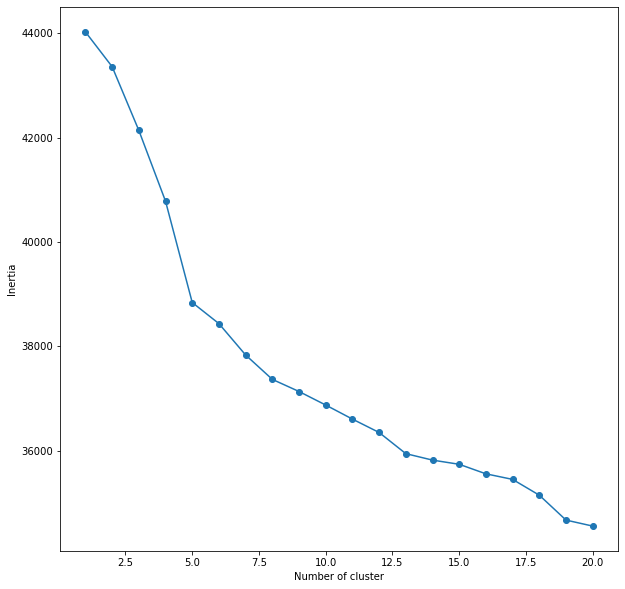

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(range(1,21), elbow)
plt.scatter(range(1,21), elbow)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

Analizing the curve we find out that it doesn't stabilize until we reach about 70 clusters, in order to be able to afford the computational heaviness of the various algorithms we choose to select 13 as a final number of clusters since we can observe a distinct improvement of the inertia from this point.

In [25]:
Our_clusters, Our_representatives, Our_i_clusters = OurKMeans(13, svd_matrix)

## KMeans ++
To implement KMeans++ and the elbow method we use sklearn library

In [ ]:
elbow2 = {}
for k in tqdm(range(1,21)):
    elbow_model = KMeans (n_clusters = k, init = 'k-means++')
    elbow_model.fit_predict(svd_matrix)
    elbow2[k] = elbow_model.inertia_

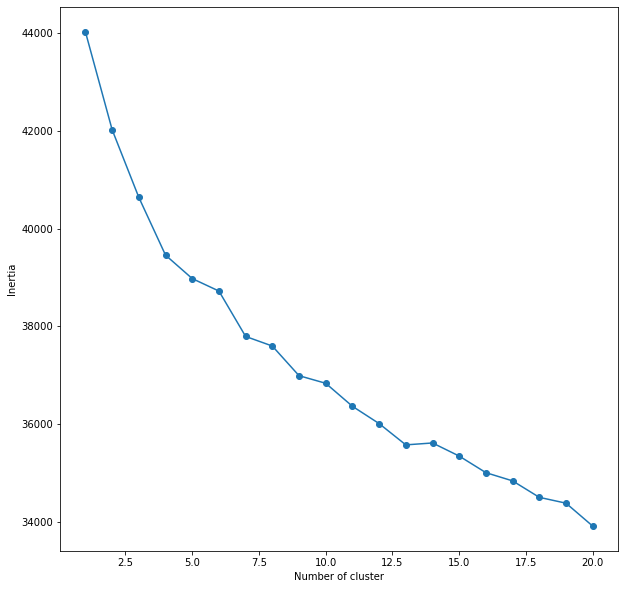

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(list(elbow2.keys())[:20], list(elbow2.values())[:20])
plt.scatter(list(elbow2.keys())[:20], list(elbow2.values())[:20])
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

For the same reasoning of before we can fix the number of clusters equal to 13.

In [ ]:
kmeans = KMeans(n_clusters=13, random_state=0, init='k-means++').fit(matrix)

### Comparison 

<b> Elbow </b> <br>
As first result we can observe that the elbow curve show an improvement on point 13 in both the plots. <br>
<b> Clusters </b> <br>
In Kmeans algorithm the initial centroids are chosen at random among the points, KMeans++ has provides a smarter rule to choose the initial representatives in order to converge to a good solution. For this difference it is possible to reach different clusters using the two algorithms, to answer this question we can compute the number of elements in each cluster.

In [36]:
#OurKmeans
for idx in range(0,len(Our_clusters)):
    print('number of product in cluster '+str(idx+1)+' : '+str(len(Our_clusters[idx])))

number of product in cluster 1 : 219
number of product in cluster 2 : 4174
number of product in cluster 3 : 4297
number of product in cluster 4 : 757
number of product in cluster 5 : 3446
number of product in cluster 6 : 2554
number of product in cluster 7 : 307
number of product in cluster 8 : 2129
number of product in cluster 9 : 4356
number of product in cluster 10 : 802
number of product in cluster 11 : 49326
number of product in cluster 12 : 935
number of product in cluster 13 : 956


In [ ]:
#Kmeans++ by sklearn
df_cluster2

,cluster,ProductId
0,1,951
1,2,41554
2,3,4158
3,4,1870
4,5,4244
5,6,794
6,7,4712
7,8,944
8,9,3385
9,10,2731


The two sets of clusters don't contain the same number of product so we can conclude that the clusters produced by KMeans and KMeans++ are different.

<b> Inertia </b> <br>
In the previous plots we can observe that the inertia takes the same range of values, in particular from 44000 to 34000 with the number of clusters that range from 0 to 20. Our KMeans shows a large drop-down until 5 clusters while KMeans++ doesn't show the same steep descent, it means that KMeans++ stabilize itself sooner that KMeans.

## Cluster Analysis

We create another column to the dataset which contains the cluster number the record belongs to, this is a possible solution to answer at the final questions.

In [40]:
kmeans = KMeans(n_clusters=13, random_state=0, init='k-means++').fit(matrix)

In [41]:
labels = kmeans.labels_

In [42]:
df['cluster'] = labels

In [43]:
df.head()

,Unnamed: 0,ProductId,Text,Text_Words,cluster
0,0,0006641040,Read it once. Read it twice. Reading Chicken S...,chicken soup rice day person chicken soup word...,1
1,1,141278509X,The best drink mix This product by Archer Farm...,drink mix archer farm drink mix packet oz wate...,0
2,2,2734888454,made in china My dogs loves this chicken but i...,dog chicken china chicken product usa isnt cha...,4
3,3,2841233731,Great recipe book for my babycook This book is...,great book babycook book ingredi store recip b...,0
4,4,7310172001,very good This product is a very health snack ...,health snack pup beef liver trick treat prici ...,4


### Identify the kind of products in the cluster

In [44]:
df_cluster = df.groupby('cluster')['Text_Words'].apply(lambda x: ' '.join(x)).reset_index()
df_cluster.cluster += 1

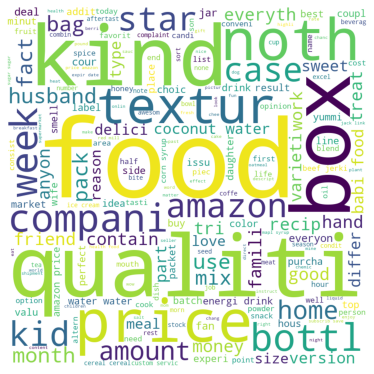

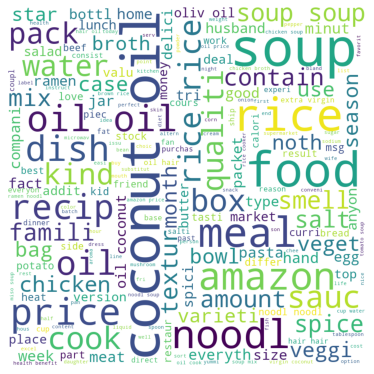

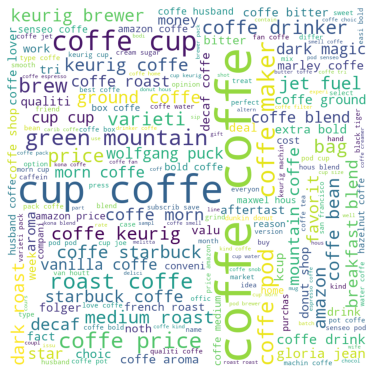

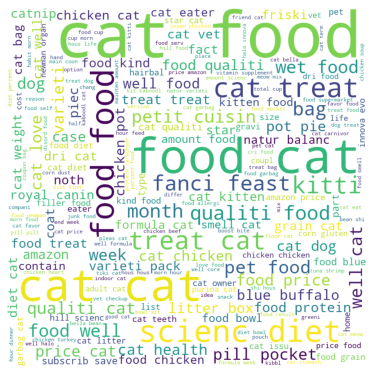

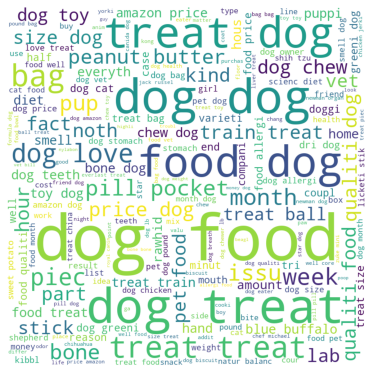

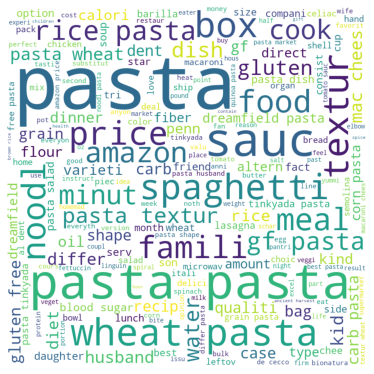

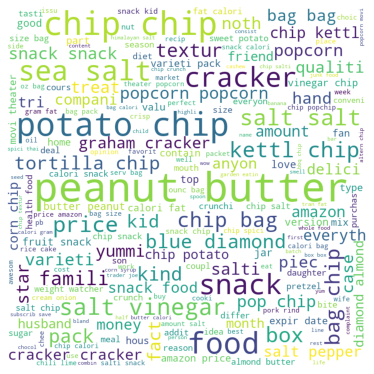

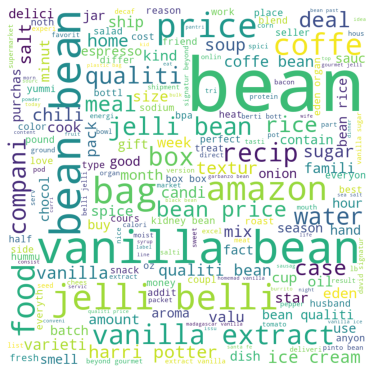

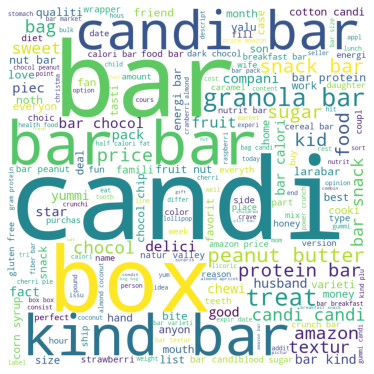

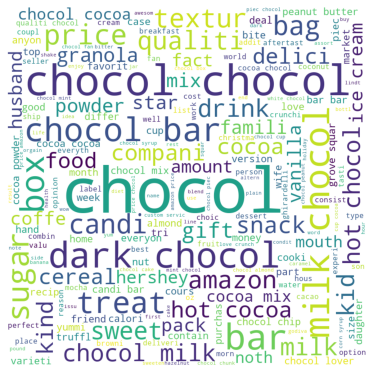

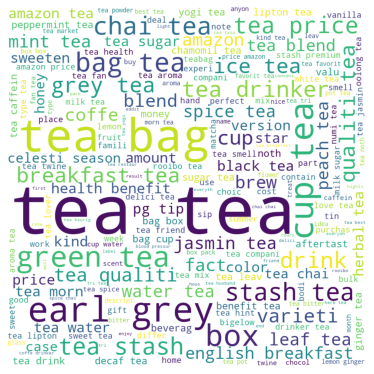

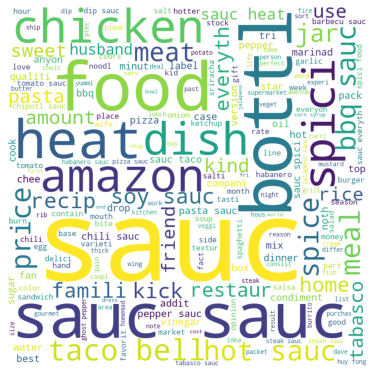

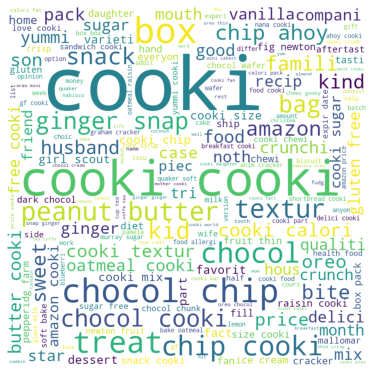

In [60]:
for i in range(len(df_cluster)):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stop_words, 
                    min_font_size = 10).generate(df_cluster.iloc[i].Text_Words) 

    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

Through these plots we can suppose that the clusters contain the following product:
- Cluster 1 : box of food 
- Cluster 2 : oils in general 
- Cluster 3 : coffe
- Cluster 4 : cat food
- Cluster 5 : dog food
- Cluster 6 : pasta and noodles 
- Cluster 7 : snack like chips, cracker and peanut butter
- Cluster 8 : bean in general (i.e. coffe beans, salty beans and candy beans)
- Cluster 9 : candies
- Cluster 10 : chocolates
- Cluster 11 : tea
- Cluster 12 : sauces
- Cluster 13 : cookies

### Provide the number of product in each cluster

In [ ]:
df_cluster2 = df.groupby('cluster')['ProductId'].count().reset_index()
df_cluster2.cluster = df_cluster2.cluster + 1

In [ ]:
df_cluster2

,cluster,ProductId
0,1,951
1,2,41554
2,3,4158
3,4,1870
4,5,4244
5,6,794
6,7,4712
7,8,944
8,9,3385
9,10,2731


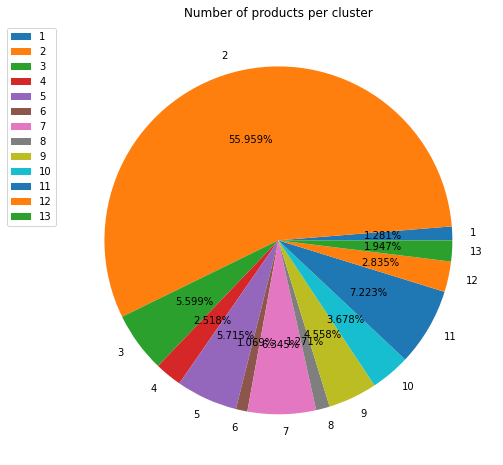

In [ ]:
lab = df_cluster2['cluster']
plt.figure(figsize=(8,8))
plt.title('Number of products per cluster')
plt.pie(df_cluster2['ProductId'], labels=lab, autopct='%.3f%%')
plt.legend(bbox_to_anchor=(0,1))
plt.show()

We can observe that the product aren't equally distributed in the clusters. <br>
The majority of product are in the cluster about oils, followed by snacks and tea. We can conclude that most of the people by on amazon buy these kind of products rather than coffee and bean.

### Compute the reviews' score distribution in each cluste

In [61]:
comb = df[['ProductId','cluster']].set_index('ProductId').T.to_dict()

In [72]:
dataset['cluster'] = dataset.ProductId.apply(lambda x: comb[x]['cluster'])
dataset.cluster = dataset.cluster+1

In [73]:
dataset

,Id,ProductId,UserId,Score,Text,cluster
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...,5
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...,7
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...,1
...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,5,Great for sesame chicken..this is a good if no...,1
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,2,I'm disappointed with the flavor. The chocolat...,10
568451,568452,B004I613EE,A121AA1GQV751Z,5,"These stars are small, so you can give 10-15 o...",5
568452,568453,B004I613EE,A3IBEVCTXKNOH,5,These are the BEST treats for training and rew...,5


In [74]:
dataset.groupby('cluster')['Score'].mean()

cluster
1     4.128506
2     4.223301
3     4.124392
4     4.186942
5     4.212277
6     4.475635
7     4.236033
8     4.261889
9     4.203923
10    4.135102
11    4.307068
12    4.322265
13    4.228937
Name: Score, dtype: float64

In [ ]:
print('|--------------------------------------------------------|')
print('| T-Test for mean differences at 90% significance level  |')
print('|--------------------------------------------------------|')
print('')
for i in range(1, 14):
    for j in range(i+1,14):
        res = round(stats.ttest_ind(dataset[dataset.cluster == i]['Score'], dataset[dataset.cluster == j]['Score'])[1],4)
        if res >= 0.10:
            print('Pvalue from test of clusters', i, 'and', str(j)+':', res ,'==> • Significant! •')
        else:
            print('Pvalue from test of clusters', i, 'and', str(j)+':', res ,'==> Not significant')

|--------------------------------------------------------|
| T-Test for mean differences at 90% significance level |
|--------------------------------------------------------|

Pvalue from test of clusters 1 and 2: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 3: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 4: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 5: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 6: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 7: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 8: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 9: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 10: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 11: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 12: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 13: 0.0 ==> Not significant
Pvalue from test of clusters 2 and 3: 0.2851 ==> Significant!
Pvalue from t

>The test measures whether the expected value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, *then we cannot reject the null hypothesis of identical average scores*.

We can see that, despite the means are very similar between each other, only a for a few of them we cannot reject the hypothesis of identical average score.

### Unique users writing reviews in each cluster

In [ ]:
obj = dataset.groupby('cluster')['UserId'].nunique().reset_index()

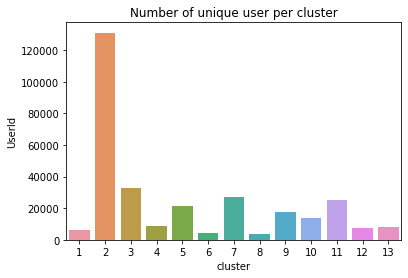

In [ ]:
ax = sns.barplot(x="cluster", y="UserId", data=obj)
plt.title('Number of unique user per cluster')
plt.show()

As we expect the cluster with the majority of different users reviews is the one with the largest number of product.

##  Bonus

For this question we decided to use a toy dataset in order to show the evolution of the clusters in a 2D space.

In [131]:
import pyspark
from pyspark import SparkContext

In [123]:
sc = SparkContext.getOrCreate()

In [148]:
cols = ['x','y','label']
df = pd.read_csv('Aggregation.txt', sep = '\t', header=None, names=cols)
df.head()

,x,y,label
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2


<AxesSubplot:xlabel='0', ylabel='1'>

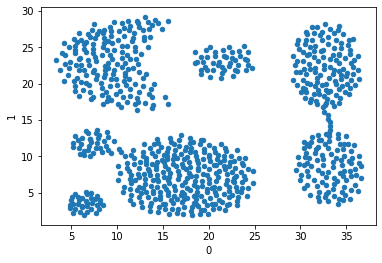

In [125]:
df.plot(x=0,y=1,kind='scatter')

In [126]:
x = df[0].to_list()
y = df[1].to_list()
points = np.array(list(zip(x,y)))

In [129]:
def kMap(x, mu):
    distances = np.zeros((mu.shape[0]))
    for i in range(mu.shape[0]):
        distances[i] = np.linalg.norm(x-mu[i])
    return (np.argmin(distances), (x, 1))

In [12]:
def kReduce(x):
    x = list(x)
    return [sum(i) for i in zip(*x)]

In [67]:
def means(x):
    x = list(x)
    return x[0][0] / x[0][1]

In [103]:
def getCentroidsFromTup(x):
    return np.array([i[1] for i in x])

In [178]:
def toList(x):
    l = []
    for i in x:
        l.append([i[1][0][0], i[1][0][1],i[0]])
    return l

In [203]:
def plot(clusters):
    l = toList(clusters.collect())
    df_clust = pd.DataFrame(l, columns = cols)
    ax = sns.scatterplot(data=df_clust,x='x', y='y', hue='label',palette="deep")
    plt.show()

In [207]:
def KMeans(x, k):
    centroids = x[np.random.choice(x.shape[0], k, replace=False), :]
    x = sc.parallelize(x)
    while 1:
        step0 = x.map(lambda x: kMap(x, centroids))
        plot(step0)
        step1 = step0.groupByKey().mapValues(lambda x: kReduce(x))
        new_centroids = getCentroidsFromTup(step1.groupByKey().mapValues(lambda x: means(x)).collect())
        if np.all(new_centroids != centroids):
            centroids = new_centroids
        else:
            return centroids, step0.collect()
    

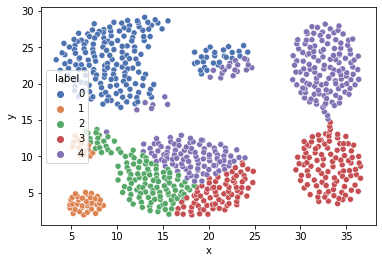

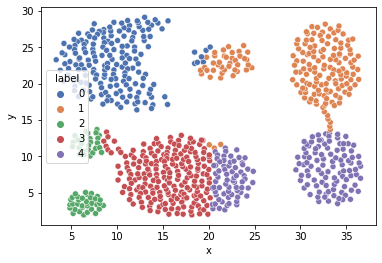

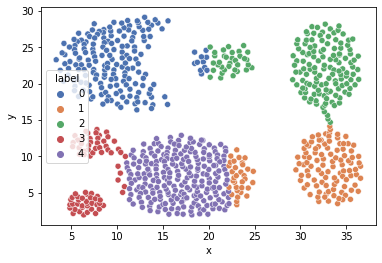

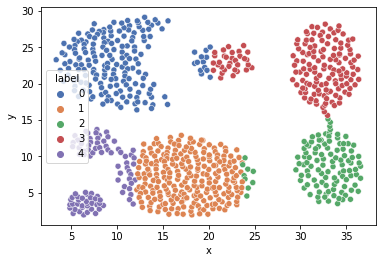

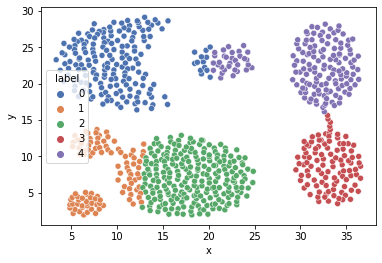

In [212]:
cent, clusters = KMeans(points,5)

# [Q3] Algorithmic question
-------
The algorithm counting sort solve our problem

In [19]:
A = [2,8,3,2,4,2]
b = 8
s = 1

<b> Step 1 </b> preparing the vector we need <br>
<b> Running Time </b> $\theta(r+1+n)=\theta(r+n)$ where r is the difference between b and s and n is the lenght of the input array A

In [20]:
r = [0]*(b-s+1) #vector of zeros with lenght r+1
B = [0](len(A)) #in this vector we'll store A sorted 

<b> Step 2 </b> we costruct r such that r[i] contains the occurence of elements of A (SORTED) <br>
<b> Running Time </b> $\theta(n)$

In [25]:
for i in range(len(A)): 
    r[A[i]-s] += 1

<b> Step 3 </b> we change r using the comulative count <br>
<b> Running Time </b> $\theta(r-1) = \theta(r)$

In [26]:
for i in range(1, len(r)): 
    r[i] += r[i-1] #cumulative count

<b> Step 4 </b> computing the sorted A using r <br>
<b> Running Time </b> $\theta(n-1) = \theta(n)$

In [23]:
for i in range(len(A)-1, -1, -1): 
    B[r[A[i] - s] - 1] = A[i] 
    r[A[i] - s] -= 1

In [27]:
print(B)

[2, 2, 2, 3, 4, 8]


<b> Total Running Time </b> $\theta(n+r)$